In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle 

import sys
import os
import torch as pt
from tqdm import tqdm

# Add the project root
sys.path.append(os.path.abspath('../../'))

from src.useful_functions import read_dirs_paths
from src.isokann.modules3 import *

# For matplotlib
font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# For reproducibility
np.random.seed(0)
pt.manual_seed(0)

# Read directory paths
read_dirs_paths('dir_paths.txt', globals())

device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
print("")
print(device)


Created variables:
inp_dir = input/
out_trajectories1 = output/trajectories/
out_trajectories2 = output/trajectories/openmm_files/
out_trajectories3 = output/trajectories/openmm_files/initial_states/
out_trajectories4 = output/trajectories/openmm_files/final_states/
out_trajectories5 = output/trajectories/openmm_files/final_states_nh/
out_isokann = output/isokann/
out_mokito = output/mokito/

cuda


In [2]:
# Load initial and final states and convert to torch
D0 = pt.load(out_trajectories1 + 'BAT_0.pt', map_location=device)
DT = pt.load(out_trajectories1 + 'BAT_t.pt', map_location=device)

Npoints = D0.shape[0]
Ndims   = D0.shape[1]

Nfinpoints  = DT.shape[1]
Nframes     = DT.shape[0]


# Load from the file
with open(out_isokann + 'hyperparameters.pkl', 'rb') as file:
    best_hyperparams = pickle.load(file)


print("The best hyperparameters are:", best_hyperparams)


The best hyperparameters are: {'Nepochs': 15, 'nodes': array([1716,  858,  429,    1]), 'learning_rate': 0.01, 'weight_decay': 0.005, 'batch_size': 100, 'patience': 5, 'act_fun': 'leakyrelu'}


In [3]:
# Power method iterations
Niters    = 400

# NN hyperparameters
Nepochs   = best_hyperparams['Nepochs']
nodes     = best_hyperparams['nodes']
lr        = best_hyperparams['learning_rate']
wd        = best_hyperparams['weight_decay']
bs        = best_hyperparams['batch_size']
patience  = best_hyperparams['patience']
act_fun   = best_hyperparams['act_fun']


tolerance = 0.0001

rates = np.zeros((Nframes, 2))

tau = 500 * 0.002 /10

for frame in tqdm(range(7,Nframes)): 
    Dt = pt.clone(DT[frame,:,:,:])

    # Define the interpolating function
    f_NN = NeuralNetwork( Nodes = np.asarray(nodes) ).to(device)

    N = 10
    chi_0 = np.zeros(Npoints)
    chi_t = np.zeros(Npoints)
    for _ in range(N):
        train_LOSS, val_LOSS, best_loss, convergence = power_method(    D0, 
                                                                        Dt,
                                                                        f_NN,
                                                                        scale_and_shift,
                                                                        Niters = Niters,
                                                                        Nepochs = Nepochs,
                                                                        tolerance  = tolerance,
                                                                        lr = lr,
                                                                        wd = wd,
                                                                        batch_size = 300,
                                                                        patience = patience,
                                                                        print_eta  = False,
                                                                        test_size = 0.2,
                                                                        loss = 'full'
                                                                    )

        chi_   =  f_NN(D0).cpu().detach().numpy()
        chi__  =  f_NN(Dt).cpu().detach().numpy()
        chi__  =  np.mean( chi__, axis=1 )

        if frame > 0:
            if np.corrcoef(chi_0, chi_)[0,1]<0:
                chi_ = 1 - chi_

            if np.corrcoef(chi_0, chi__)[0,1]<0:
                chi__ = 1 - chi__

        chi_0 = chi_0 + chi_
        chi_t = chi_t + chi__

    chi_0 = chi_0 / N
    chi_t = chi_t / N

    r1, r2, q = exit_rates_from_chi((frame+1) * tau, chi_0, chi_t)
    rates[frame,:] = r1, r2

  0%|          | 0/3 [00:00<?, ?it/s]/scratch/htc/ldonati/anaconda32/envs/emma32/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/scratch/htc/ldonati/anaconda32/envs/emma32/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
 33%|███▎      | 1/3 [00:15<00:31, 15.82s/it]

Slope $\chi$: 0.9862509179453686
Intercept $\chi$: 0.007006191137900131
 
Slope $1-\chi$: 0.9862509179453688
Intercept $1-\chi$: 0.006742890916731303
 
Exit rate 1: 0.008487093141178603
Exit rate 2: 0.008818501958071363
 
Rate matrix:
[[-0.00848709  0.00848709]
 [ 0.0088185  -0.0088185 ]]


 67%|██████▋   | 2/3 [00:57<00:31, 31.00s/it]

Slope $\chi$: 0.98725685061814
Intercept $\chi$: 0.006095556060150886
 
Slope $1-\chi$: 0.98725685061814
Intercept $1-\chi$: 0.0066475933217092775
 
Exit rate 1: 0.007433680292228422
Exit rate 2: 0.006816363872100715
 
Rate matrix:
[[-0.00743368  0.00743368]
 [ 0.00681636 -0.00681636]]


100%|██████████| 3/3 [01:31<00:00, 30.52s/it]

Slope $\chi$: 0.9854987684546078
Intercept $\chi$: 0.00819627716893867
 
Slope $1-\chi$: 0.985498768454608
Intercept $1-\chi$: 0.006304954376453398
 
Exit rate 1: 0.006351115988412398
Exit rate 2: 0.008256286067273026
 
Rate matrix:
[[-0.00635112  0.00635112]
 [ 0.00825629 -0.00825629]]


In [4]:
rates

array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.00848709, 0.0088185 ],
       [0.00743368, 0.00681636],
       [0.00635112, 0.00825629]])

/tmp/ipykernel_41984/3551393915.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/rates,'.')


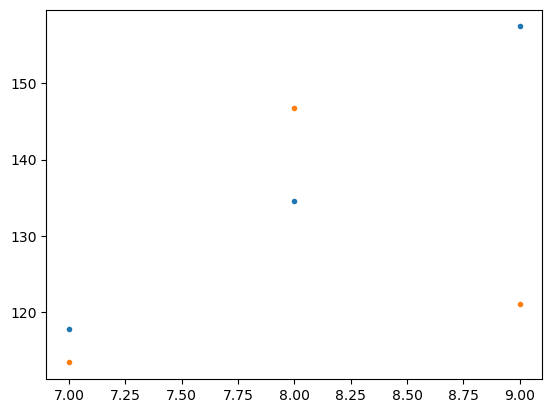

In [5]:
plt.plot(1/rates,'.')